# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 02/20/2025

This script:
1. Opens the CSV files with the CFS forecasts. 
2. Runs the forecast through the trained Gaussian Process model. 
3. Produces an ensemble of RNBS forecasts for each of the Great Lakes.
4. Saves the forecast to a CSV file.
5. Creates a timeseries plot and saves it as a PNG file. 

This script needs the following files:

- input
    - GP_trained_model.joblib
    - x_scaler.joblib
    - y_scaler.joblib
- data
    - CFS_EVAP_forecasts_Avgs_MM.csv
    - CFS_PCP_forecasts_Avgs_MM.csv
    - CFS_TMP_forecasts_Avgs_K.csv

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import calendar
import matplotlib.pyplot as plt
import os

Matplotlib is building the font cache; this may take a moment.


User Input

In [32]:
# This is the directory where you cloned the repo
path_to_repo = '/Users/ljob/Desktop/'

# Path to download data to
dir = path_to_repo + 'cnbs-predictor/data/input/'

# Read in the CSVs
tmp_csv = dir + 'CFS_TMP_forecasts_Avgs_K.csv'
evap_csv = dir + 'CFS_EVAP_forecasts_Avgs_MM.csv'
pcp_csv = dir + 'CFS_PCP_forecasts_Avgs_MM.csv'

# Open the trained model(s)
GP_model = joblib.load(dir + 'GP_trained_model.joblib')
LR_model = joblib.load(dir + 'LR_trained_model.joblib')
RF_model = joblib.load(dir + 'RF_trained_model.joblib')
NN_model = joblib.load(dir + 'NN_trained_model.joblib')

# Open scalers
x_scaler = joblib.load(dir + 'x_scaler.joblib')
y_scaler = joblib.load(dir + 'y_scaler.joblib')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.5.1. This 

# Define Functions

Determine the mean/median, min, and max RNBS values for each month from the ensemble members.

In [9]:
def calculate_median_confidence(df,lake):
    median = df.groupby(['year', 'month'])[lake].median().reset_index()

    # Calculate the 2.5th and 97.5th percentiles for the confidence band
    lower_bound = df.groupby(['year', 'month'])[lake].quantile(0.025).reset_index()
    upper_bound = df.groupby(['year', 'month'])[lake].quantile(0.975).reset_index()

    return median, lower_bound, upper_bound

Calculate the number of seconds in a month based on the month and the year. This is used to calculate units between cms and mm.

In [10]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

Convert a dataframe in [cms] to [mm].

In [11]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_mm[column] = df_mm[column] / sa_eri * df_mm['seconds'] * 1000
        elif column.startswith("sup"):
            df_mm[column] = df_mm[column] / sa_sup * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mih * df_mm['seconds'] * 1000
        elif column.startswith("ont"):
            df_mm[column] = df_mm[column] / sa_ont * df_mm['seconds'] * 1000

    # Deleting column 'seconds'
    df_mm.drop('seconds', axis=1)

    return df_mm

In [12]:
def convert_mm_to_cms(df_mm):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_cms = df_mm.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_cms['seconds'] = df_cms.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_mm / 1000 [to convert to m] * surface_area / seconds_in_a_month
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_eri) / df_cms['seconds']
        elif column.startswith("sup"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_sup) / df_cms['seconds']
        elif column.startswith("mih"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_mih) / df_cms['seconds']
        elif column.startswith("ont"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_ont) / df_cms['seconds']

    # Deleting column 'seconds'
    df_cms.drop('seconds', axis=1)

    return df_cms

In [ ]:
def format_predictions(y_pred_scaled, y_scaler):
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    # Convert to dataframe and add column names
    df_y_pred = pd.DataFrame(y_pred, columns=['sup_evap', 'sup_pcp', 'sup_rnoff',
                                              'eri_evap', 'eri_pcp', 'eri_rnoff',
                                              'ont_evap', 'ont_pcp', 'ont_rnoff',
                                              'mih_evap', 'mih_pcp', 'mih_rnoff'])
    # Add back the columns with cfs_run, forecast_year, forecast_month
    df_y_pred[['cfs_run', 'year', 'month']] = pcp_data[['cfs_run', 'forecast_year', 'forecast_month']].astype(int)

    # Calculate CNBS for all the lakes
    for lake in ['sup', 'eri', 'ont', 'mih']:
        df_y_pred[f'{lake}_cnbs'] = df_y_pred[f'{lake}_pcp'] + df_y_pred[f'{lake}_rnoff'] - df_y_pred[f'{lake}_evap']

    # Reorder the columns to move 'year' and 'month' to the left
    df_y_pred = df_y_pred[['cfs_run', 'year', 'month'] + [col for col in df_y_pred.columns if col not in {'cfs_run', 'year', 'month'}]]

    return df_y_pred

In [28]:
def filter_predictions(df_y_pred):
    current_day = datetime.now().day
    current_month = datetime.now().month
    current_year = datetime.now().year

    # Determine filtering condition based on the day of the month
    if current_day >= 26:
        # Remove this month and all previous months
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            (df_y_pred['year'] == current_year) & (df_y_pred['month'] > current_month)
        ]
        print(f"First month forecast: {current_month+1}")
    else:
        # Keep this month
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
        ]
        print(f"First month forecast: {current_month}")
    return filtered_y_pred

# Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [15]:
## Read in PCP data from CFSR [mm]
pcp_data = pd.read_csv(pcp_csv,sep=',')

## Read in EVAP data from CFSR [mm]
evap_data = pd.read_csv(evap_csv,sep=',')

## Read in TMP data from CFSR [K]
tmp_data = pd.read_csv(tmp_csv,sep=',')

In [16]:
X = pd.DataFrame({
    'sup_pcp_w': pcp_data['sup_lake'],
    'eri_pcp_w': pcp_data['eri_lake'],
    'ont_pcp_w': pcp_data['ont_lake'],
    'mih_pcp_w': pcp_data['mih_lake'],
    'sup_pcp_l': pcp_data['sup_land'],
    'eri_pcp_l': pcp_data['eri_land'],
    'ont_pcp_l': pcp_data['ont_land'],
    'mih_pcp_l': pcp_data['mih_land'],
    'sup_evap_w': evap_data['sup_lake'],
    'eri_evap_w': evap_data['eri_lake'],
    'ont_evap_w': evap_data['ont_lake'],
    'mih_evap_w': evap_data['mih_lake'],
    'sup_evap_l': evap_data['sup_land'],
    'eri_evap_l': evap_data['eri_land'],
    'ont_evap_l': evap_data['ont_land'],
    'mih_evap_l': evap_data['mih_land'],
    'sup_tmp_w': tmp_data['sup_lake'],
    'eri_tmp_w': tmp_data['eri_lake'],
    'ont_tmp_w': tmp_data['ont_lake'],
    'mih_tmp_w': tmp_data['mih_lake'],
    'sup_tmp_l': tmp_data['sup_land'],
    'eri_tmp_l': tmp_data['eri_land'],
    'ont_tmp_l': tmp_data['ont_land'],
    'mih_tmp_l': tmp_data['mih_land']
})

Standardize the data

In [29]:
# Standardize the data
X_scaled = x_scaler.transform(X)

Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [30]:
# Predict CNBS using GP
y_pred_scaled_gp = GP_model.predict(X_scaled)
y_pred_scaled_lr = LR_model.predict(X_scaled)
y_pred_scaled_rf = RF_model.predict(X_scaled)
y_pred_scaled_nn = NN_model.predict(X_scaled)

527/527 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


In [31]:
y_pred_gp = format_predictions(y_pred_scaled_gp, y_scaler)
y_pred_lr = format_predictions(y_pred_scaled_lr, y_scaler)
y_pred_rf = format_predictions(y_pred_scaled_rf, y_scaler)
y_pred_nn = format_predictions(y_pred_scaled_nn, y_scaler)

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

If the current day is later than the 26th day of the month, the first forecast month needs to be the next month. This was a request by USACE.

In [22]:
def filter_predictions(df_y_pred):
    current_day = datetime.now().day
    current_month = datetime.now().month
    current_year = datetime.now().year

    # Determine filtering condition based on the day of the month
    if current_day >= 26:
        # Remove this month and all previous months
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            (df_y_pred['year'] == current_year) & (df_y_pred['month'] > current_month)
        ]
        print(f"First month forecast: {current_month+1}")
    else:
        # Keep this month
        filtered_y_pred = df_y_pred[
            (df_y_pred['year'] > current_year) |
            ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
        ]
        print(f"First month forecast: {current_month}")
    return filtered_y_pred

In [23]:
y_filtered_gp = filter_predictions(y_pred_gp)
y_filtered_lr = filter_predictions(y_pred_lr)
y_filtered_rf = filter_predictions(y_pred_rf)
y_filtered_nn = filter_predictions(y_pred_nn)

First month forecast: 3
First month forecast: 3
First month forecast: 3
First month forecast: 3


Save the CNBS forecast to a CSV file.

In [138]:
y_filtered_gp.to_csv(dir+'CNBS_forecasts_mm_GP.csv',sep=',',index=False)
y_filtered_lr.to_csv(dir+'CNBS_forecasts_mm_LR.csv',sep=',',index=False)
y_filtered_rf.to_csv(dir+'CNBS_forecasts_mm_RF.csv',sep=',',index=False)
y_filtered_nn.to_csv(dir+'CNBS_forecasts_mm_NN.csv',sep=',',index=False)

Convert CNBS from [mm] to [cms] and save to a new CSV file.

In [140]:
df_y_cms_gp = convert_mm_to_cms(y_filtered_gp)
df_y_cms_lr = convert_mm_to_cms(y_filtered_lr)
df_y_cms_rf = convert_mm_to_cms(y_filtered_rf)
df_y_cms_nn = convert_mm_to_cms(y_filtered_nn)

Save CNBS [cms] to a seperate CVS

In [141]:
df_y_cms_gp.to_csv(dir+'CNBS_forecasts_cms_GP.csv',sep=',',index=False)
df_y_cms_lr.to_csv(dir+'CNBS_forecasts_cms_LR.csv',sep=',',index=False)
df_y_cms_rf.to_csv(dir+'CNBS_forecasts_cms_RF.csv',sep=',',index=False)
df_y_cms_nn.to_csv(dir+'CNBS_forecasts_cms_NN.csv',sep=',',index=False)

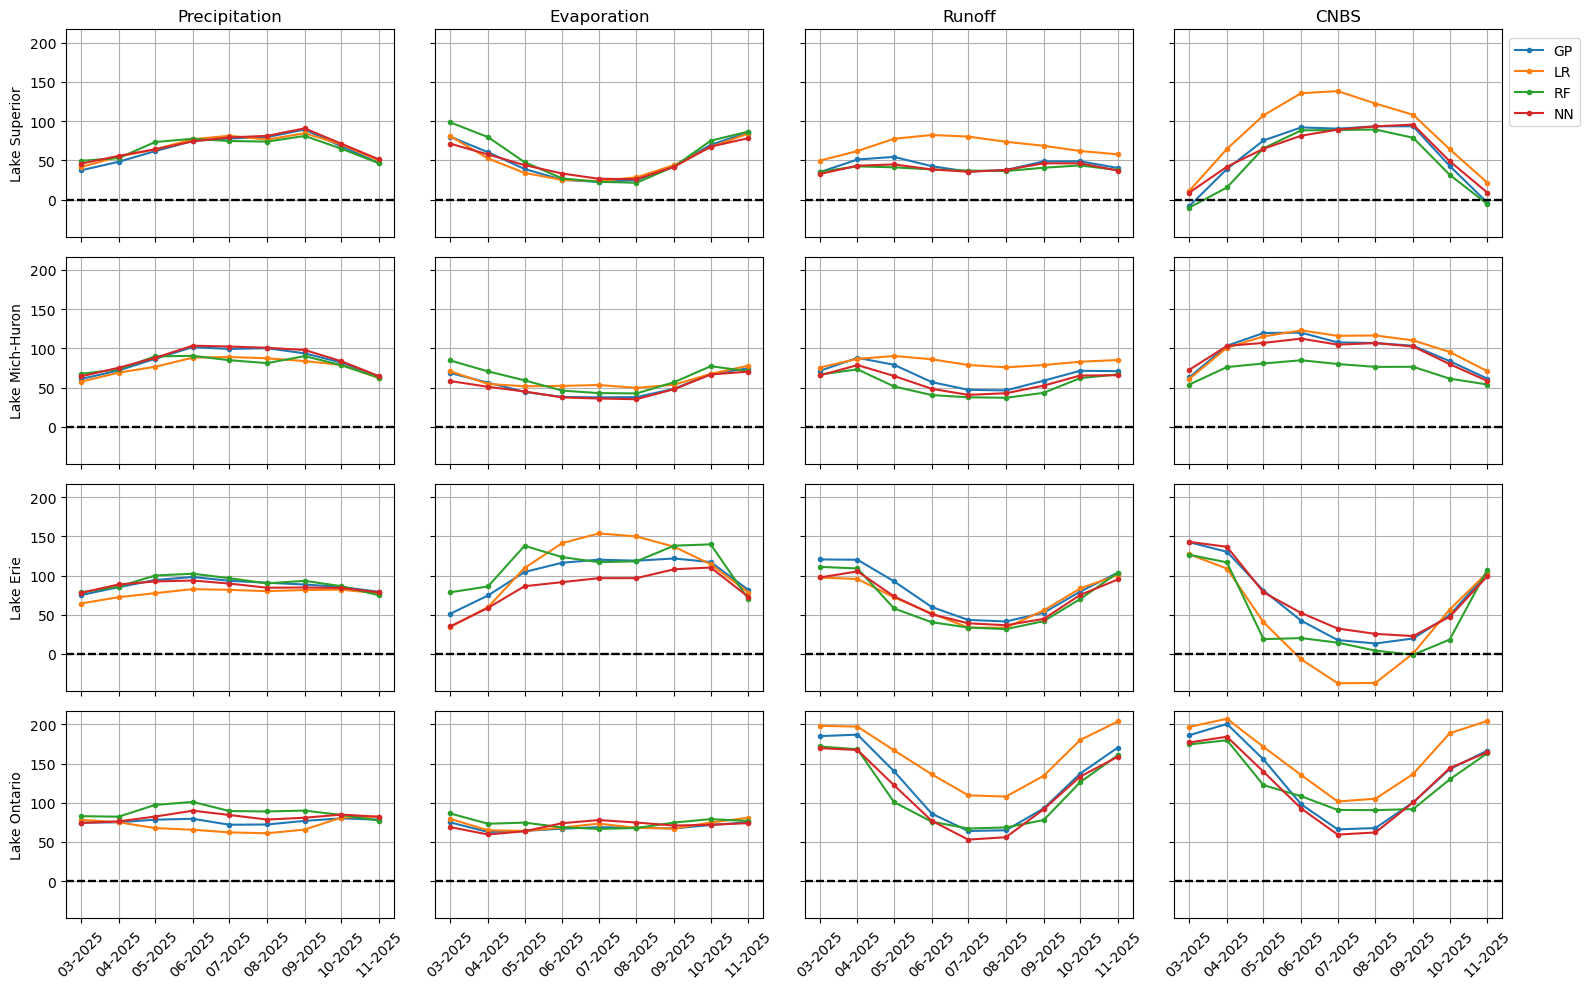

In [37]:
import matplotlib.pyplot as plt

# List of datasets
datasets = [y_filtered_gp, y_filtered_lr, y_filtered_rf, y_filtered_nn]

# Columns of interest
columns = ['sup_pcp', 'sup_evap', 'sup_rnoff', 'sup_cnbs',
           'mih_pcp', 'mih_evap', 'mih_rnoff', 'mih_cnbs',
           'eri_pcp', 'eri_evap', 'eri_rnoff', 'eri_cnbs',
           'ont_pcp', 'ont_evap', 'ont_rnoff', 'ont_cnbs']

legend_labels = ['GP', 'LR', 'RF', 'NN']

# Create a 1x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(16, 10))

global_y_min = 0
global_y_max = 0

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index (integer division by 4)
    col = i % 4   # Column index (remainder after division by 4)

    for dataset_index, dataset in enumerate(datasets):
        # Group by year and month, and get the median for the current column
        median_df = dataset.groupby(['year', 'month'])[column].median().reset_index()
        
        # Add a 'date' column to the median DataFrame
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))
        
        # Plot the medians for the current dataset on the same subplot
        axs[row, col].plot(median_df['date'], median_df[column], marker='o', markersize = 3, label=legend_labels[dataset_index])
        axs[row, col].axhline(0, color='black', linestyle='--')
        axs[row, col].grid(True)

        # Update the global y-axis limits based on the current dataset
        current_y_min = median_df[column].min()
        current_y_max = median_df[column].max()
        
        # Update global min/max based on this dataset's range
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    if row == 0:
        if col == 0:
            axs[row, col].set_title('Precipitation')
        elif col == 1:
            axs[row, col].set_title('Evaporation')
        elif col == 2:
            axs[row, col].set_title('Runoff')
        elif col == 3:
            axs[row, col].set_title('CNBS')
    else:
        axs[row, col].set_title('')

    if row == 3:
        axs[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y'))
        axs[row, col].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
    else:
        axs[row, col].set_xticklabels([])
    if col == 0:
        if row == 0:
            axs[row, col].set_ylabel('Lake Superior')
        elif row == 1:
            axs[row, col].set_ylabel('Lake Mich-Huron')
        elif row == 2:
            axs[row, col].set_ylabel('Lake Erie')
        elif row == 3:
            axs[row, col].set_ylabel('Lake Ontario')
    else: 
        axs[row, col].set_yticklabels([])  # Only far left column gets y labels

    # Add a legend
    #axs[row, col].legend()
for row in range(0,4):
    for col in range(0,4):
        axs[row, col].set_ylim(global_y_min - 10, global_y_max + 10)

axs[0,3].legend(loc='lower left', bbox_to_anchor=(1,0.5))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
